# NEU PCA
---

## Parameters

In [1]:
PCA_Rank = 3

#### NEW IMPORTS - TBD

In [2]:
from sklearn.decomposition import PCA
from sklearn import datasets

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import math
import datetime

In [3]:
# First Round Initializations (Global Level) #
#============================================#
# Load Dependances and makes path(s)
exec(open('Initializations_Dump.py').read())
# Load Hyper( and meta) parameter(s)
exec(open('HyperParameter_Grid.py').read())
# %run Helper_Functions.ipynb
exec(open('Helper_Functions.py').read())
# Load Models
# %run Architecture_Builder.ipynb
exec(open('Architecture_Builder.py').read())
# Initialize "Fun Run Mode"
First_run = True

Using TensorFlow backend.


Parameter Grids Build and Loaded!
Complete NEU-Structure Building Procedure!!!
Complete NEU-Structure Building Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Deep Feature Builder - Ready
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN (Fully Coupled) Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Complete NEU-PCA Training Procedure!!!


In [4]:
# ## TEMPS!!
# is_visuallty_verbose = False
# First_run = False

## Prepare Data

### Load Data

In [5]:
if First_run:
    # Load Data
    yield_data = pd.read_excel('inputs/data/ust_daily.ods', engine='odf')

### Format Data

In [6]:
if First_run:
    yield_data['date'] = pd.to_datetime(yield_data['date'],infer_datetime_format=True)
    yield_data.set_index('date', drop=True, inplace=True)
    yield_data.index.names = [None]

### Sub-set Data

In [7]:
if First_run:
    # # Get indices
    N_train_step = int(round(yield_data.shape[0]*Train_step_proportion,0))
    N_test_set = int(yield_data.shape[0] - round(yield_data.shape[0]*Train_step_proportion,0))
    # # Get Datasets
    X_train = yield_data[:N_train_step]
    X_test = yield_data[-N_test_set:]
    # Transpose
    X_train_T = X_train.T
    X_test_T = X_test.T
    
    
    # # Update User
    print('#================================================#')
    print(' Training Datasize: '+str(X_train.shape[0])+' and test datasize: ' + str(X_test.shape[0]) + '.  ')
    print('#================================================#')
    
    # # Set First Run to Off
    First_run = False

#================================================#
 Training Datasize: 5126 and test datasize: 1708.  
#================================================#


# Data Visualization

## Tabular 

In [8]:
if is_visuallty_verbose:
    print('Training Dataset Preview:')
    print(X_train.head())

X_train.head()

,BC_1MONTH,BC_3MONTH,BC_6MONTH,BC_1YEAR,BC_2YEAR,BC_3YEAR,BC_5YEAR,BC_7YEAR,BC_10YEAR,BC_20YEAR,BC_30YEAR,BC_30YEARDISPLAY
1990-06-08,0.0,7.96,8.03,8.07,8.33,8.38,8.42,8.51,8.46,0.0,8.44,0.0
1990-06-07,0.0,7.96,8.01,8.07,8.34,8.38,8.41,8.49,8.46,0.0,8.43,0.0
1990-06-11,0.0,7.99,8.07,8.09,8.36,8.41,8.43,8.52,8.48,0.0,8.45,0.0
1990-06-13,0.0,7.93,7.99,8.02,8.27,8.32,8.35,8.44,8.40,0.0,8.39,0.0
1990-06-12,0.0,7.99,8.05,8.09,8.36,8.42,8.44,8.52,8.48,0.0,8.45,0.0


In [9]:
if is_visuallty_verbose:
    print('Testing Dataset Preview:')
    print(X_test.head())
    
X_test.head()

,BC_1MONTH,BC_3MONTH,BC_6MONTH,BC_1YEAR,BC_2YEAR,BC_3YEAR,BC_5YEAR,BC_7YEAR,BC_10YEAR,BC_20YEAR,BC_30YEAR,BC_30YEARDISPLAY
2010-10-01,0.15,0.16,0.19,0.26,0.42,0.63,1.26,1.90,2.54,3.40,3.71,0.0
2010-09-30,0.14,0.16,0.19,0.27,0.42,0.64,1.27,1.91,2.53,3.38,3.69,0.0
2010-09-21,0.12,0.17,0.20,0.26,0.43,0.68,1.34,1.99,2.61,3.49,3.79,0.0
2010-09-20,0.12,0.17,0.20,0.26,0.47,0.73,1.43,2.10,2.72,3.57,3.87,0.0
2010-09-22,0.12,0.16,0.19,0.25,0.44,0.68,1.33,1.96,2.56,3.43,3.74,0.0


## Time-Series

/usr/lib64/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  if __name__ == '__main__':


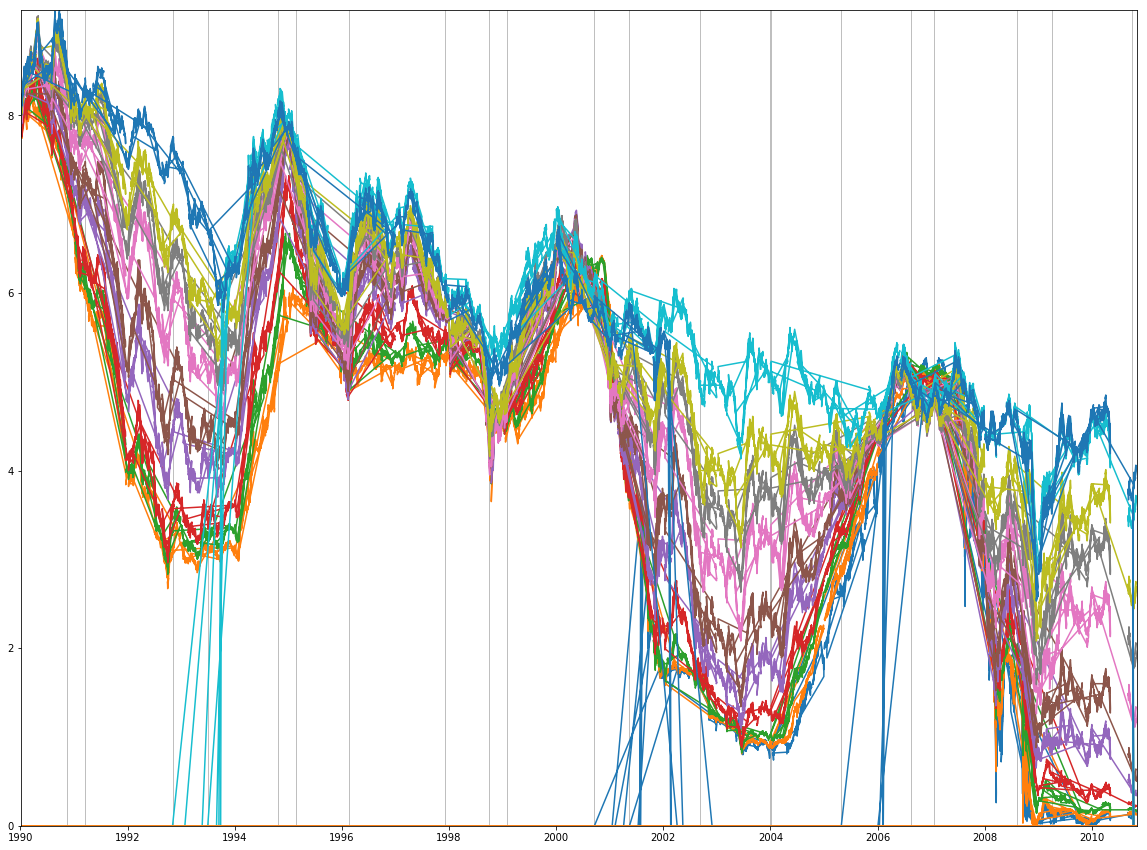

In [12]:
plt.figure(figsize=(20,15))

plt.plot(X_train.index, X_train)
plt.xlim(X_train.index.min(), X_train.index.max())
plt.ylim(np.min(X_train.min()),np.max(X_train.max()))

plt.axhline(y=0,c="grey",linewidth=0.5,zorder=0)
for i in range(X_train.index.min().year, X_train.index.max().year+1):
    plt.axvline(x=X_train.index[X_train.index.searchsorted(pd.datetime(i,1,1))-1],
                c="grey", linewidth=0.5, zorder=0)

## Curves

In [15]:
X_train_T.ix

AttributeError: 'DataFrame' object has no attribute 'ix'

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from ipykernel import kernelapp as app


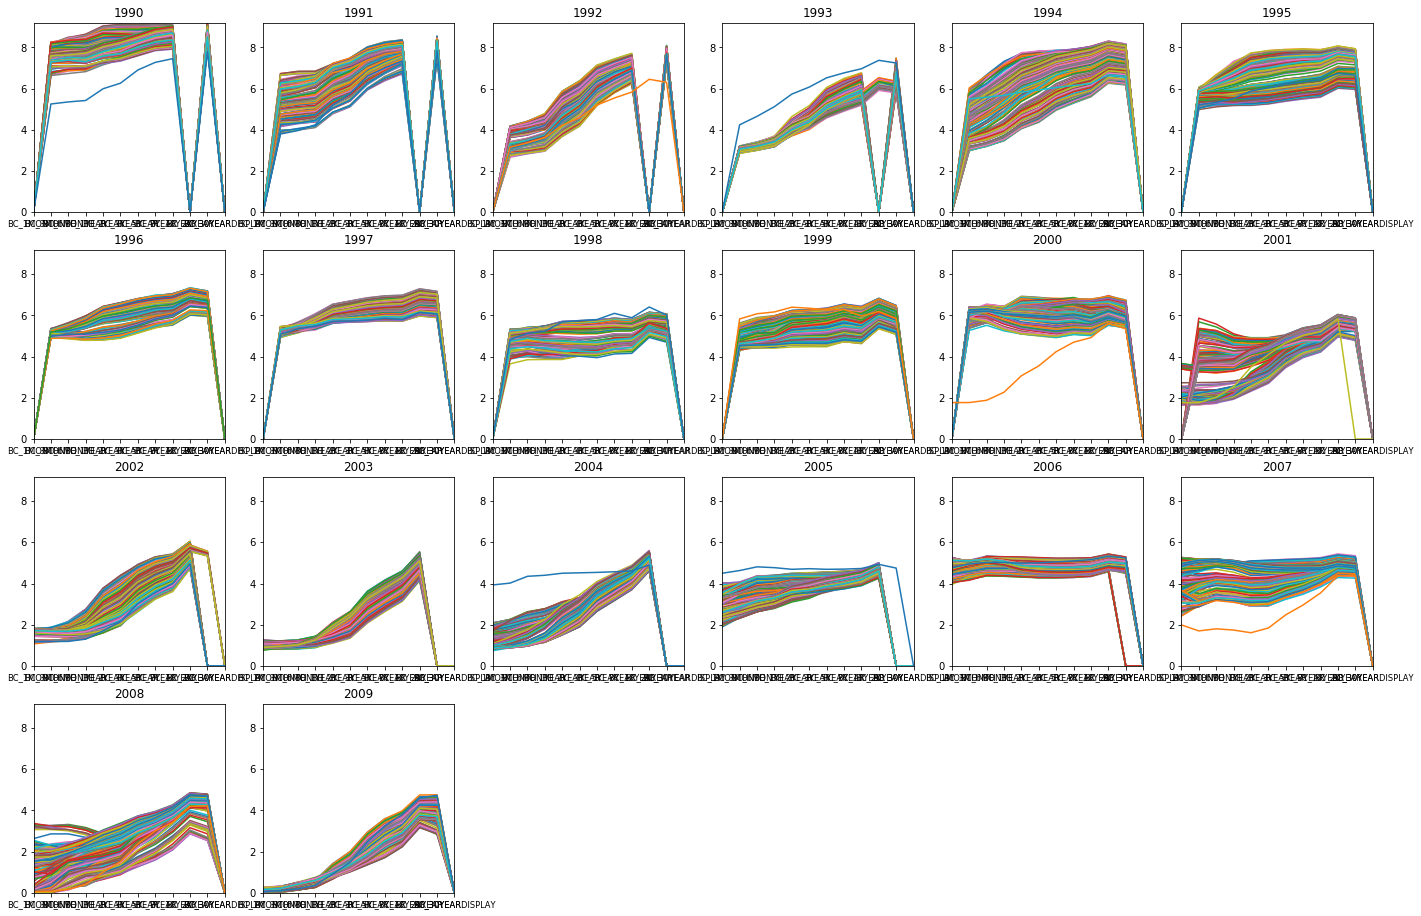

In [29]:
Ncols = 6
Nrows = 10
num_years = X_train.index.max().year-X_train.index.min().year
rows = math.ceil(num_years/Ncols)

plt.figure(figsize=(24,(24/Ncols)*rows))

plt.subplot2grid((rows,cols), (0,0), colspan=Ncols, rowspan=Nrows)


colnum = 0
rownum = 0
for year in range(X_train.index.min().year,X_train.index.max().year):
    year_start = X_train.index[X_train.index.searchsorted(pd.datetime(year,1,1))]
    year_end = X_train.index[X_train.index.searchsorted(pd.datetime(year,12,30))]
    
    plt.subplot2grid((rows,Ncols), (rownum,colnum), colspan=1, rowspan=1)
    plt.title('{0}'.format(year))
    plt.xlim(0, len(X_train_T.index)-1)
    plt.ylim(np.min(X_train_T.values), np.max(X_train_T.values))
    plt.xticks(range(len(X_train_T.index)), X_train_T.index, size='small')
    
    plt.plot(X_train_T.loc[:,year_start:year_end].values)
    
    if colnum != cols-1:
        colnum += 1
    else:
        colnum = 0
        rownum += 1

None

---

### Fix Seeds for Reproducability

In [ ]:
# Numpy
np.random.seed(2020)
# Tensorflow
tf.random.set_seed(2020)
# Python's Seed
random.seed(2020)

---

# Benchark(s)
---

## Perform PCA

### Get PCAs

In [ ]:
# Compute/Initialize PCA
pca = PCA(n_components=PCA_Rank)
pca.fit(X_train)

# Define PCA Rreconstructor
def PCA_reconstructor(x_in):
    affine_parameterizer = np.matmul(pca.components_,(x_in-pca.mean_))
    low_dimensional_reconstructed = np.matmul(np.transpose(pca.components_), affine_parameterizer) + pca.mean_
    return low_dimensional_reconstructed

### Reconstruct Curves

In [7]:
# Initialize
reconstructed_data_PCA_train = np.zeros(X_train.shape)
reconstructed_data_PCA_test = np.zeros(X_test.shape)
# Build Reconstructed Curves
## Training
for i in range(X_train.shape[0]):
    current_curve = np.array(X_train.iloc[i]).reshape(-1,)
    reconstructed_data_PCA_train[i,]=PCA_reconstructor(current_curve)
reconstructed_data_PCA_train = pd.DataFrame(reconstructed_data_PCA_train)
## Test
for i in range(X_test.shape[0]):
    current_curve = np.array(X_test.iloc[i]).reshape(-1,)
    reconstructed_data_PCA_test[i,]=PCA_reconstructor(current_curve)
reconstructed_data_PCA_test = pd.DataFrame(reconstructed_data_PCA_test)

NameError: name 'X_train' is not defined

---